In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

SAVE_PLOTS=True
STANDARD_DPI=300

In [9]:
def load_noise_data():
    noise_levels_filepath = "data\dark_pmt\I_V_noise_700_2285V.csv"
    return pd.read_csv(noise_levels_filepath)
noise_data = load_noise_data()
noise_data.head(2)

,time,pmt_high_voltage,pmt_current,v_p2p_ch1,v_rms_ch1,v_p2p_ch2,v_rms_ch2
0,1.741440e+09,700.1,67.780,0.0400,0.010568,0.0408,0.012731
1,1.741440e+09,705.1,68.495,0.0424,0.011586,0.0424,0.011411


In [13]:
# find the row inm the data that corresponds to a voltage of 1450V (rounded to the nearest whole number)
noiseat1450_row = noise_data.loc[noise_data['pmt_high_voltage'].round() == 1450]
noiseat1450_row

,time,pmt_high_voltage,pmt_current,v_p2p_ch1,v_rms_ch1,v_p2p_ch2,v_rms_ch2
150,1.741441e+09,1449.9,181.795,0.044,0.009966,0.044,0.010358


In [2]:

def load_h5_data(filename):
    data = {}
    with h5py.File(filename, 'r') as f:
        for att in f.keys():
            data[int(att)] = {'CH1': [], 'CH2': []}

            for i in f[att]['CH1']:
                arr = np.array(f[att]['CH1'][i])  # Load as NumPy array
                df = pd.DataFrame(arr, columns=['t', 'V'])  # Convert to DataFrame
                data[int(att)]['CH1'].append(df)

            for i in f[att]['CH2']:
                arr = np.array(f[att]['CH2'][i])
                df = pd.DataFrame(arr, columns=['t', 'V'])
                data[int(att)]['CH2'].append(df)

    return data

In [4]:
signals_filepath = 'data\pmt_light_attenuation\signals_20250309-104658.h5'
signals = load_h5_data(signals_filepath)
keys = sorted(signals.keys())
keys

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

In [5]:
def get_avg_p2p(key, channel):
    sigs = signals[key][channel]
    peak_to_peak = np.array([df['V'].max() - df['V'].min() for df in sigs])
    return peak_to_peak.mean()

In [14]:
df = pd.DataFrame({'attenuation': keys, 'CH1': [get_avg_p2p(k, 'CH1') for k in keys], 'CH2': [get_avg_p2p(k, 'CH2') for k in keys]})
df.head(2)

,attenuation,CH1,CH2
0,0,9.48,8.624
1,1,8.76,7.712


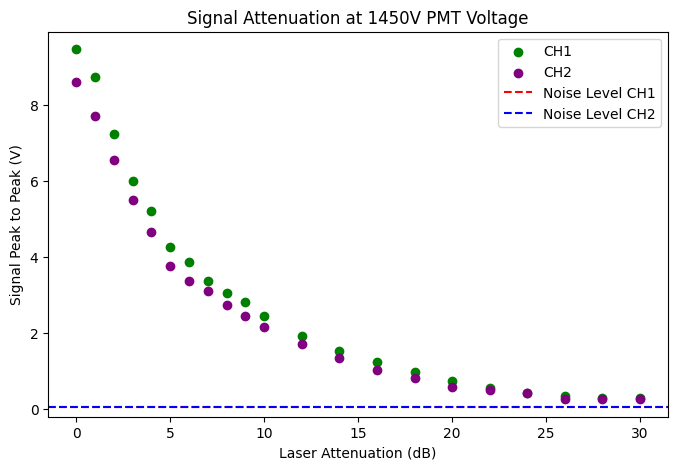

In [30]:
plt.figure(figsize=(8, 5))
plt.scatter(df['attenuation'], df['CH1'], color='green', label='CH1')
plt.scatter(df['attenuation'], df['CH2'], color = 'purple', label='CH2')

# Add horizontal lines for noise levels
plt.axhline(y=noiseat1450_row['v_p2p_ch1'].values[0], color='r', linestyle='--', label='Noise Level CH1')
plt.axhline(y=noiseat1450_row['v_p2p_ch2'].values[0], color='b', linestyle='--', label='Noise Level CH2')

plt.xlabel('Laser Attenuation (dB)')
plt.ylabel('Signal Peak to Peak (V)')
plt.title('Signal Attenuation at 1450V PMT Voltage')
plt.legend()
# plt.grid(True)

if SAVE_PLOTS:
    savefig_dir = 'plots/pmt_light_attenuation_tests/pmt1/'
    plt.savefig(savefig_dir + 'att_sig_1450V.jpg', dpi=STANDARD_DPI)

plt.show()

In [22]:
# calculate the signal to noise ratios
df['SNR_CH1'] = df['CH1'] / noiseat1450_row['v_p2p_ch1'].values[0]
df['SNR_CH2'] = df['CH2'] / noiseat1450_row['v_p2p_ch2'].values[0]
df.head(2)

,attenuation,CH1,CH2,SNR_CH1,SNR_CH2
0,0,9.48,8.624,215.454546,196.000001
1,1,8.76,7.712,199.090910,175.272728


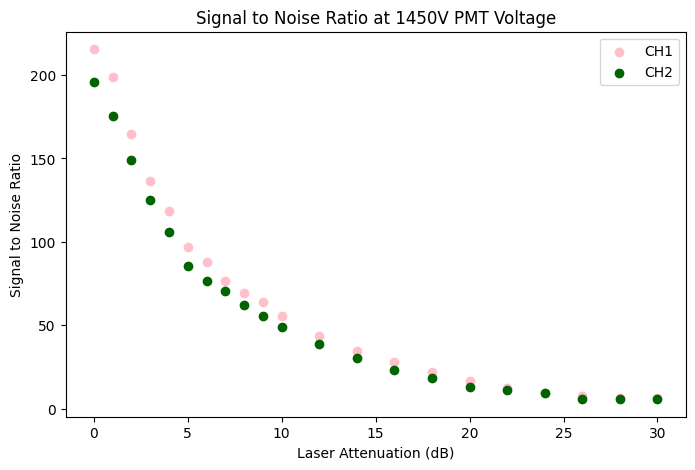

In [ ]:
# plot the signal to noise ratios
plt.figure(figsize=(8, 5))

plt.scatter(df['attenuation'], df['SNR_CH1'], color='pink', label='CH1')
plt.scatter(df['attenuation'], df['SNR_CH2'], color='darkgreen', label='CH2')

plt.xlabel('Laser Attenuation (dB)')
plt.ylabel('Signal to Noise Ratio')
plt.title('Signal to Noise Ratio at 1450V PMT Voltage')
plt.legend()
# plt.grid(True)

if SAVE_PLOTS:
    savefig_dir = 'plots/pmt_light_attenuation_tests/pmt1/'
    plt.savefig(savefig_dir + 'att_snr_1450V.jpg', dpi=STANDARD_DPI)
plt.show()